In [1]:
from jax.lib import xla_bridge
print(xla_bridge.get_backend().platform)

gpu


In [2]:
%load_ext autoreload
%autoreload 2
%pylab inline


from functools import partial
from tqdm import tqdm
import pickle
from pathlib import Path
import tensorboard
import numpy as np
import jax
import jax.numpy as jnp

import flax.linen as nn
from flax.metrics import tensorboard

from haiku._src.nets.resnet import ResNet18
import optax
import haiku as hk

import tensorflow_datasets as tfds
import tensorflow as tf
from tensorflow_probability.substrates import jax as tfp

tfd = tfp.distributions
tfb = tfp.bijectors
tfd = tfp.distributions

from sbi_lens.gen_dataset.lensing_lognormal_dataset import LensingLogNormalDataset
from sbi_lens.gen_dataset.utils import augmentation_noise, augmentation_flip
from sbi_lens.config import config_lsst_y_10


'unset XLA_FLAGS'


Populating the interactive namespace from numpy and matplotlib


/linkhome/rech/genmfd01/ulm75uc/.local/lib/python3.10/site-packages/flax/struct.py:144: FutureWarning: jax.tree_util.register_keypaths is deprecated, and will be removed in a future release. Please use `register_pytree_with_keys()` instead.
  jax.tree_util.register_keypaths(data_clz, keypaths)
2023-06-23 19:21:29.650378: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
/gpfslocalsup/pub/anaconda-py3/2021.05/envs/python-3.10.4/lib/python3.10/site-packages/requests/__init__.py:102: RequestsDependencyWarning: urllib3 (1.26.14) or chardet (5.1.0)/charset_normalizer (2.0.12) doesn't match a supported version!
  warnings.warn("urllib3 ({}) or chardet ({})/charset_normalizer ({}) doesn't match a supported "
/linkhome/rech/genmfd01/ulm75uc/.local/lib/python3.10/site-packages/haiku/_src/data_structures.py:37: FutureWarning: jax.tree_structure is deprecated, and will be removed in a future release. Use jax.tree_util.tree_structure instead.
  PyTreeD

'unset XLA_FLAGS'

In [3]:
import logging


import tensorflow_probability as tfp; tfp = tfp.substrates.jax

# this prints a WARNING

tfp.distributions.TransformedDistribution(
    tfp.distributions.Normal(0.0, 1.0), tfp.bijectors.Identity()
)

logger = logging.getLogger("root")


class CheckTypesFilter(logging.Filter):
    def filter(self, record):
        return "check_types" not in record.getMessage()


logger.addFilter(CheckTypesFilter())

# this does not print a WARNING

tfp.distributions.TransformedDistribution(tfp.distributions.Normal(0.0, 1.0), tfp.bijectors.Identity())

<tfp.distributions.TransformedDistribution 'identityNormal' batch_shape=[] event_shape=[] dtype=float32>

## Dataset configuration

In [4]:
N = config_lsst_y_10.N
map_size = config_lsst_y_10.map_size
sigma_e = config_lsst_y_10.sigma_e
gals_per_arcmin2 = config_lsst_y_10.gals_per_arcmin2
nbins = config_lsst_y_10.nbins
a = config_lsst_y_10.a
b = config_lsst_y_10.b
z0 = config_lsst_y_10.z0

truth = config_lsst_y_10.truth

params_name = config_lsst_y_10.params_name

tf.random.set_seed(1)

augmentation = lambda example: augmentation_flip(
    augmentation_noise(example=example,
                       N=N,
                       map_size=map_size,
                       sigma_e=sigma_e,
                       gal_per_arcmin2=gals_per_arcmin2,
                       nbins=nbins,
                       a=a,
                       b=b,
                       z0=z0))


# Build compressor

In [5]:
dim = 6
aug_dim = int((dim * (dim + 1) / 2)+dim)

In [14]:
def aug_compressor(y):
    net_0=ResNet18(6)(y,is_training=True)
    net=jax.nn.leaky_relu(net_0)
    net=hk.Linear(128)(net)
    net=jnp.tanh(net)
    net=hk.Linear(aug_dim)(net)
    return net#net_0, net #net0= VMIM if the posterior is gaussian, net=VMIM if the posterior is gaussian and use alle the 27 paramaters, otherwise it;s the same to use the mean fo the gaussian posterior




In [15]:
compressor=hk.transform_with_state(aug_compressor)


In [16]:
parameters_compressor, opt_state_resnet = compressor.init(
    jax.random.PRNGKey(0), y=0.5 * jnp.ones([1, N, N, nbins]))

# Dataset

In [17]:
ds = tfds.load('LensingLogNormalDataset/year_10_without_noise_score_density', 
               split='train[:80000]', 
               data_dir = 'tensorflow_dataset')

In [18]:
ds = ds.repeat()
ds = ds.shuffle(1000)
ds = ds.map(augmentation)
ds = ds.batch(128)
ds = ds.prefetch(tf.data.experimental.AUTOTUNE)
ds_train = iter(tfds.as_numpy(ds))


## Training

In [19]:
total_steps=20_000
lr_scheduler = optax.piecewise_constant_schedule(
    init_value=0.001,
    boundaries_and_scales={
        int(2000): 0.1,
        int(4000): 0.1,
        int(6000): 0.7,
        int(8000): 0.7,
        int(10000): 0.7,
    })

optimizer_c = optax.adam(learning_rate=lr_scheduler)
opt_state_c = optimizer_c.init(parameters_compressor)


In [20]:

def loss_gnll(params, theta, x, state_resnet):
    y, opt_state_resnet = compressor.apply(params, state_resnet, None, x)
    gmu = y[..., :6]
    gtril = y[..., 6:]
    dist = tfd.MultivariateNormalTriL(
        loc=gmu,
        scale_tril=tfp.bijectors.FillScaleTriL(
            diag_bijector=tfp.bijectors.Softplus(),diag_shift=1e-03)(gtril)
            )
    return -mean(dist.log_prob(theta)), opt_state_resnet



def update(
    model_params,
    opt_state,
    theta,
    x,
    state_resnet=None
  ):

    (loss, opt_state_resnet), grads = jax.value_and_grad(
      loss_gnll,
      has_aux=True
    )(model_params, theta, x, state_resnet)

    updates, new_opt_state = optimizer_c.update(
      grads,
      opt_state
    )

    new_params = optax.apply_updates(
      model_params,
      updates
    )

    return loss, new_params, new_opt_state, opt_state_resnet



In [21]:
store_loss = []


summary_writer = tensorboard.SummaryWriter('logs/')

for batch in tqdm(range(total_steps + 1)):
  ex = next(ds_train)
  if not jnp.isnan(ex['simulation']).any():
        l, parameters_compressor, opt_state_c, opt_state_resnet = update(
            model_params=parameters_compressor,
            opt_state=opt_state_c,
            theta=ex['theta'],
            x=ex['simulation'],
            state_resnet=opt_state_resnet)
        summary_writer.scalar('train_loss_big', l, batch)
        summary_writer.scalar('learning_rate_big',lr_scheduler(batch),  batch)
        store_loss.append(l)
        if jnp.isnan(l):
          print('NaN Loss')
          break
            



100%|██████████| 20001/20001 [6:49:59<00:00,  1.23s/it]  


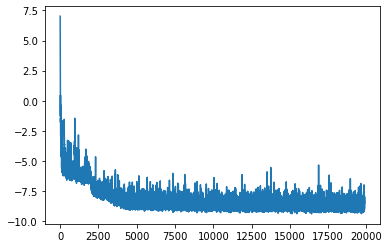

In [22]:
plt.plot(store_loss)

In [23]:
import pickle

with open("params_nd_compressor_gnll_net.pkl", "wb") as fp:
  pickle.dump(parameters_compressor, fp)

with open("opt_state_resnet_gnll_net.pkl", "wb") as fp:
  pickle.dump(opt_state_resnet, fp)

with open("loss_compressor_gnll_net.pkl", "wb") as fp:
  pickle.dump(jnp.asarray(store_loss), fp)
